### Analysis Overview

This notebook aggregates OULAD VLE click logs into per-student daily engagement trajectories for a single course presentation (AAA 2013J). It visualizes cohort-level engagement patterns using descriptive statistics and explores trajectory groupings via clustering.


In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

info_path = "info_path"
vle_path  = "vle_path"

info = pd.read_csv(info_path)
vle  = pd.read_csv(
    vle_path,
    engine="python",
    on_bad_lines="skip"
)

# 选 AAA 2013J 学生
aaa_info = info[
    (info["code_module"] == "AAA") &
    (info["code_presentation"] == "2013J")
]

aaa_vle = vle.merge(
    aaa_info[["id_student", "code_module", "code_presentation"]],
    on=["id_student", "code_module", "code_presentation"],
    how="inner"
)

# 每个学生每天总点击
daily = aaa_vle.groupby(["id_student", "date"])["sum_click"].sum().reset_index()


In [3]:
# 学习轨迹矩阵  行是学生 列是 day
trajectory = daily.pivot(
    index="id_student",
    columns="date",
    values="sum_click"
).fillna(0)

# day 平移到从 0 开始
trajectory.columns = trajectory.columns - trajectory.columns.min()

# 7 天滚动平均
smooth_traj = trajectory.rolling(window=7, axis=1, min_periods=1).mean()

# 行内归一化到 0–1
row_min = smooth_traj.min(axis=1)
row_max = smooth_traj.max(axis=1)
smooth_norm = (smooth_traj.sub(row_min, axis=0)
                           .div((row_max - row_min + 1e-8), axis=0))

smooth_norm_clipped = smooth_norm.clip(0, 1)


/tmp/ipython-input-2410352756.py:12: FutureWarning: Support for axis=1 in DataFrame.rolling is deprecated and will be removed in a future version. Use obj.T.rolling(...) instead
  smooth_traj = trajectory.rolling(window=7, axis=1, min_periods=1).mean()


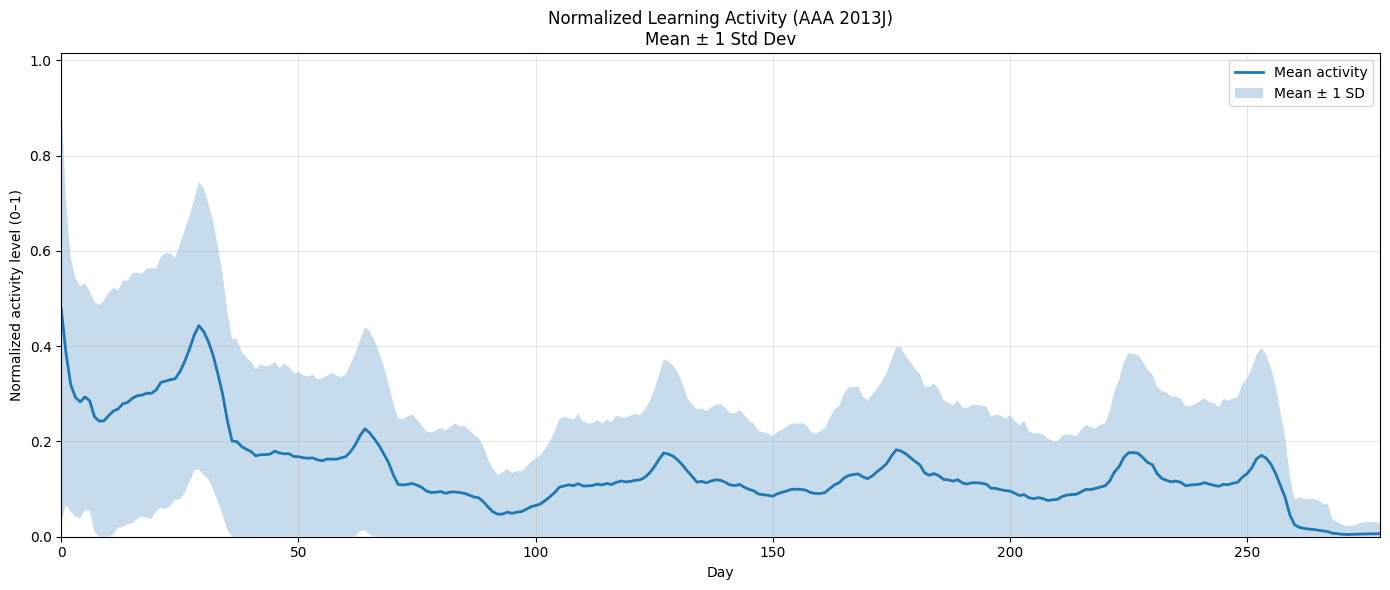

In [4]:
days   = smooth_norm.columns
values = smooth_norm.values

mean_all = values.mean(axis=0)
std_all  = values.std(axis=0)

upper = np.clip(mean_all + std_all, 0, 1)
lower = np.clip(mean_all - std_all, 0, 1)

y_max = upper.max()        # 自动取最大值
y_max = float(y_max * 1.1) # 留一点空间

plt.figure(figsize=(14, 6))

plt.plot(days, mean_all, linewidth=2, label="Mean activity")
plt.fill_between(days, lower, upper, alpha=0.25, label="Mean ± 1 SD")

plt.title("Normalized Learning Activity (AAA 2013J)\nMean ± 1 Std Dev")
plt.xlabel("Day")
plt.ylabel("Normalized activity level (0–1)")
plt.xlim(days.min(), days.max())
plt.ylim(0, y_max)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


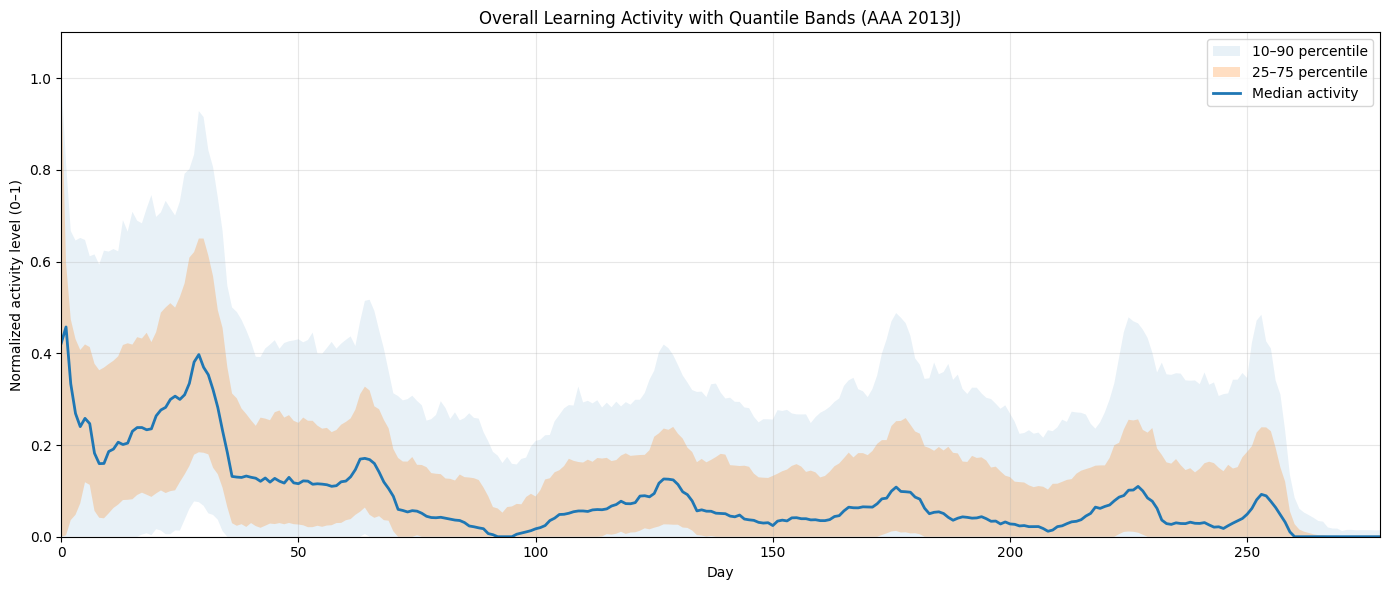

In [5]:
days   = smooth_norm.columns
values = smooth_norm.values

p10 = np.percentile(values, 10, axis=0)
p25 = np.percentile(values, 25, axis=0)
p50 = np.percentile(values, 50, axis=0)
p75 = np.percentile(values, 75, axis=0)
p90 = np.percentile(values, 90, axis=0)

y_max = p90.max()
y_max = float(y_max * 1.1)

plt.figure(figsize=(14, 6))

plt.fill_between(days, p10, p90,
                 alpha=0.10, label="10–90 percentile")
plt.fill_between(days, p25, p75,
                 alpha=0.25, label="25–75 percentile")
plt.plot(days, p50, linewidth=2, label="Median activity")

plt.title("Overall Learning Activity with Quantile Bands (AAA 2013J)")
plt.xlabel("Day")
plt.ylabel("Normalized activity level (0–1)")
plt.xlim(days.min(), days.max())
plt.ylim(0, y_max)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [6]:
k = 5
kmeans = KMeans(n_clusters=k, random_state=42, n_init="auto")
labels = kmeans.fit_predict(smooth_norm_clipped)

pattern_names = {
    0: "Minimal activity",
    1: "Low steady",
    2: "Moderate active",
    3: "High engaged",
    4: "Early burst"
}

cluster_avg = []
for c in range(k):
    group = smooth_norm_clipped[labels == c]
    cluster_avg.append(group.values.mean())

high_cluster_id = int(np.argmax(cluster_avg))
high_cluster_id


4

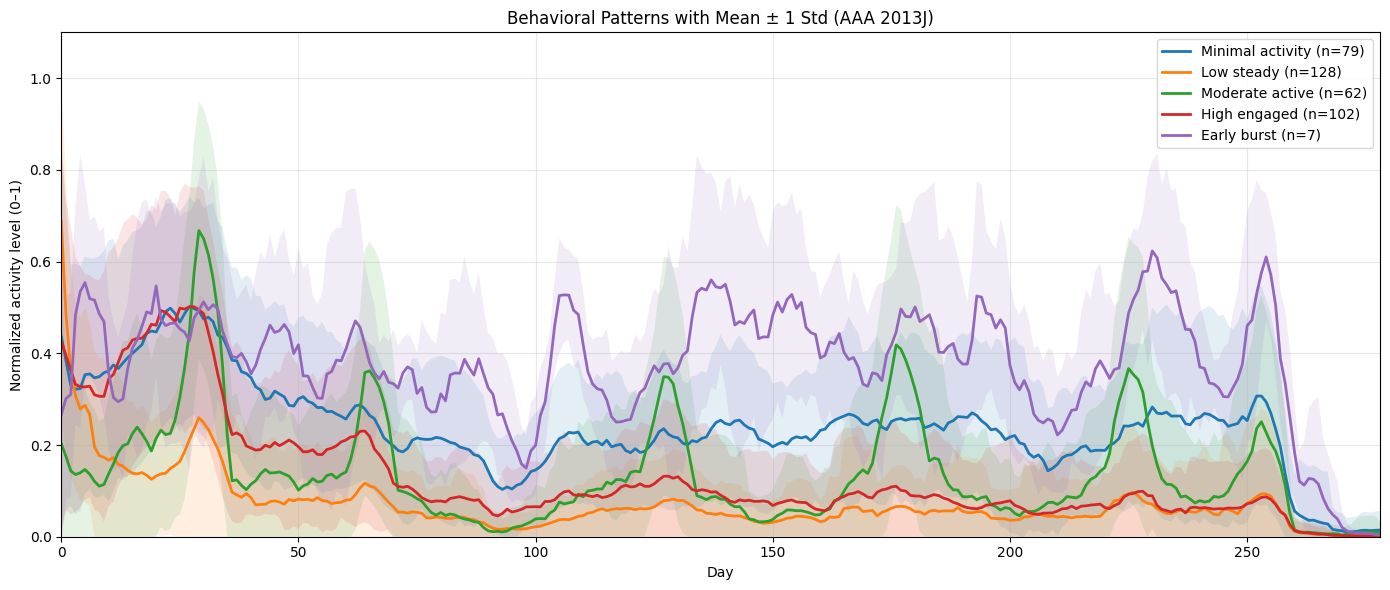

In [7]:
days = smooth_norm.columns

plt.figure(figsize=(14, 6))

global_upper_max = 0.0

for c in range(k):
    group = smooth_norm[labels == c]
    n_c   = group.shape[0]

    mean_curve = group.mean(axis=0).values
    std_curve  = group.std(axis=0).values

    upper = np.clip(mean_curve + std_curve, 0, 1)
    lower = np.clip(mean_curve - std_curve, 0, 1)

    global_upper_max = max(global_upper_max, upper.max())

    label_name = pattern_names.get(c, f"Cluster {c}")
    plt.plot(days, mean_curve, linewidth=2,
             label=f"{label_name} (n={n_c})")
    plt.fill_between(days, lower, upper, alpha=0.12)

y_max = float(global_upper_max * 1.1)

plt.title("Behavioral Patterns with Mean ± 1 Std (AAA 2013J)")
plt.xlabel("Day")
plt.ylabel("Normalized activity level (0–1)")
plt.xlim(days.min(), days.max())
plt.ylim(0, y_max)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


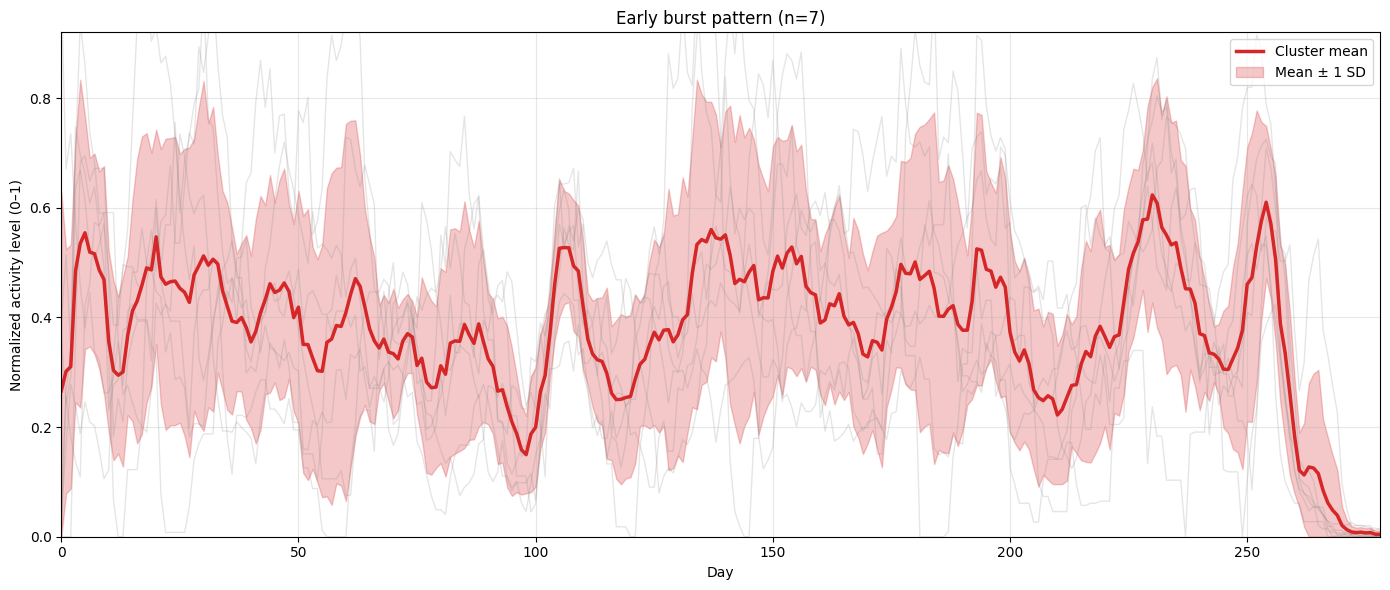

In [8]:
days = smooth_norm.columns

c = high_cluster_id
group = smooth_norm[labels == c]
n_c   = group.shape[0]

mean_curve = group.mean(axis=0).values
std_curve  = group.std(axis=0).values

upper = np.clip(mean_curve + std_curve, 0, 1)
lower = np.clip(mean_curve - std_curve, 0, 1)

y_max = float(upper.max() * 1.1)

plt.figure(figsize=(14, 6))

# 画一些个体轨迹
sample_ids = group.sample(n=min(25, n_c), random_state=42).index
for sid in sample_ids:
    plt.plot(days, group.loc[sid],
             color="gray", alpha=0.2, linewidth=1)

# 画均值 + 带
plt.plot(days, mean_curve,
         color="tab:red", linewidth=2.5,
         label="Cluster mean")
plt.fill_between(days, lower, upper,
                 color="tab:red", alpha=0.25,
                 label="Mean ± 1 SD")

title_name = pattern_names.get(c, f"Cluster {c}")
plt.title(f"{title_name} pattern (n={n_c})")
plt.xlabel("Day")
plt.ylabel("Normalized activity level (0–1)")
plt.xlim(days.min(), days.max())
plt.ylim(0, y_max)
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()


In [9]:
from pathlib import Path

PROJECT_ROOT = Path("..").resolve()
DATA_DIR = PROJECT_ROOT / "data" / "raw"

info_path = DATA_DIR / "studentInfo.csv"
vle_path = DATA_DIR / "studentVle.csv"